### Try DeepAR
* PytorchForecasting [Get Started](https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html)
* DeepAR [doc](https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.deepar.DeepAR.html)

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, DeepAR
from pytorch_forecasting.data import GroupNormalizer

import warnings
warnings.filterwarnings('ignore')

# Used Yujie's cleaned version
DIR_BYID = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/local_data/content/databyid'

ls_all_invest_ids = sorted([int(fn.split('.')[0]) for fn in os.listdir(os.path.join(DIR_BYID, 'target'))])

/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f_cols = [f"f_{i}" for i in range(300)]
# Read a subset for testing
# n = 2
ls_dfs = []
# for id in ls_all_invest_ids[:n]:
for id in ls_all_invest_ids:
    df_f_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'feats/{id}.npy')), columns=f_cols)
    df_t_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'target/{id}.npy')), columns=['target'])
    df_f_id['investment_id'] = id
    df_f_id = df_f_id[['investment_id'] + f_cols] # reorder columns
    ls_dfs.append(pd.concat([df_t_id, df_f_id], axis=1))

df = pd.concat(ls_dfs).reset_index().rename(columns={'index': 'time_id'})
df = df.sort_values(by=['time_id']) # sort by time before splitting

# # Use a few features for testing
# df = df.iloc[:, :6]
# f_cols = [c for c in df.columns if 'f_' in c]

df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=2/9, shuffle=False)

In [3]:
df_train

,time_id,target,investment_id,f_0,f_1,f_2
0,0,0.000000,0,0.000000,0.000000,0.000000
1220,0,-0.300875,1,0.932573,0.113691,-0.402206
1221,1,-0.917045,1,0.373575,0.296349,0.019102
1,1,0.000000,0,0.000000,0.000000,0.000000
2,2,0.000000,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
851,851,0.215225,0,0.304855,-1.116719,0.286537
2072,852,0.000000,1,0.023042,-1.143757,0.051038
852,852,-0.103114,0,0.023042,-1.143757,0.051038
2073,853,0.000000,1,0.125338,-0.784968,-0.026920


### Create dataset and dataloaders
* Ref: https://pytorch-forecasting.readthedocs.io/en/stable/data.html

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import NormalDistributionLoss

# define dataset
max_encoder_length = 6
max_prediction_length = 1

# create validation and training dataset
batch_size = 128
max_prediction_length = 3 # prediction horizon
max_encoder_length = 24   # lookback steps

# create the dataset from the pandas dataframe
train_dataset = TimeSeriesDataSet(
    df_train,
    group_ids=["investment_id"],
    target="target",
    time_idx="time_id",
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_reals=[],
    time_varying_known_reals=f_cols,
    time_varying_unknown_reals=['target'], # Need this for DeepAR
    target_normalizer=GroupNormalizer(
        groups=["investment_id"], 
        # transformation="softplus" # NOTE: do not use softplus or relu for encoder normalization with DeepAR
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, df_val, predict=True, stop_randomization=True)

# create dataloaders for model
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=32)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=32)


In [5]:

x, y = next(iter(train_dataloader))
# print("x =", x)
# print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

# sizes of x =
# 	encoder_cat = torch.Size([64, 24, 0])    # (B, encoder_len, in_categorical_feats)
# 	encoder_cont = torch.Size([64, 24, 304]) # (B, encoder_len, in_continuous_feats)
# 	encoder_target = torch.Size([64, 24])    # (B, encoder_len)
# 	encoder_lengths = torch.Size([64])       # (B, )
# 	decoder_cat = torch.Size([64, 3, 0])     # (B, decoder_len, out_categorical_feats) 
# 	decoder_cont = torch.Size([64, 3, 304])  # (B, decoder_len, out_continuous_feats)
# 	decoder_target = torch.Size([64, 3])     # (B, decoder_len)
# 	decoder_lengths = torch.Size([64])       # (B, )
# 	decoder_time_idx = torch.Size([64, 3])   # (B, decoder_len)
# 	groups = torch.Size([64, 1])             # (B, n_investment_id)
# 	target_scale = torch.Size([64, 2])       # (B, )



sizes of x =
	encoder_cat = torch.Size([128, 24, 0])
	encoder_cont = torch.Size([128, 24, 8])
	encoder_target = torch.Size([128, 24])
	encoder_lengths = torch.Size([128])
	decoder_cat = torch.Size([128, 3, 0])
	decoder_cont = torch.Size([128, 3, 8])
	decoder_target = torch.Size([128, 3])
	decoder_lengths = torch.Size([128])
	decoder_time_idx = torch.Size([128, 3])
	groups = torch.Size([128, 1])
	target_scale = torch.Size([128, 2])


### Configure DeepAR model (Han 2022-4-21 update)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 52.4k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Finding best initial lr:  76%|███████▌  | 76/100 [00:15<00:05,  4.77it/s]
LR finder stopped early after 76 steps due to diverging loss.
Restoring states from the checkpoint path at /media/user/12TB1/HanLi/GitHub/CMU11785-project/src/notebooks/.lr_find_022e35a5-07e7-4098-92e2-e7698dbba487.ckpt


suggested learning rate: 0.17782794100389226


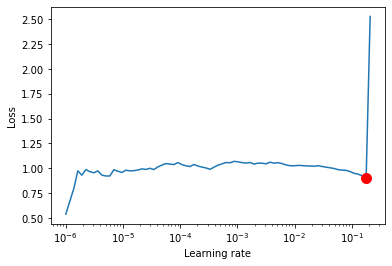

In [6]:
# configure network and trainer
# pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

model = DeepAR.from_dataset(
    train_dataset,
    learning_rate=0.03,
    hidden_size=64,  # most important hyperparameter apart from learning rate
    dropout=0.1,  # between 0.1 and 0.3 are good values
    loss=NormalDistributionLoss(),
    # # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {model.size()/1e3:.1f}k")


# find optimal learning rate
res = trainer.tuner.lr_find(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


### Train Model (Han 2022-4-21 update)

* Note: use tensorboard to check the logs: run ```tensorboard --logdir=<logging_folder>```
* To visualize tensorboard in Jupyter Notebook: 
    ```
    %reload_ext tensorboard
    %tensorboard --logdir=<logging_folder>
    ```

In [7]:
from pytorch_lightning.loggers import WandbLogger
DIR_LOGS = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs' # Change this!
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

checkpoint_callback = ModelCheckpoint(
    monitor='val_SMAPE', 
    dirpath='/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs/model_checkpoints/', 
    save_top_k=2, 
    filename='500-default-{epoch:02d}-{val_SMAPE:.2f}'
)

logger = WandbLogger(
    entity="11785_project",
    project="project_runs",
    name='DeepAR_first_run',
    log_model=True
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    # limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)

model = DeepAR.from_dataset(
    train_dataset,
    cell_type='LSTM',
    rnn_layers=3,
    learning_rate=0.03,
    hidden_size=256,  # most important hyperparameter apart from learning rate
    dropout=0.1,  # between 0.1 and 0.3 are good values
    # loss=NormalDistributionLoss(),
    # # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

# fit network
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tsbyq_wb (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.3 M 
4 | distribution_projector | Linear                 | 514   
------------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.302     Total estimated model params size (MB)


Number of parameters in network: 1325.6k
Epoch 3: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s, loss=0.85, v_num=xq4f, train_loss_step=0.00358, val_loss=1.350, train_loss_epoch=0.820]

Exception ignored in: <function _releaseLock at 0x7f9e4a009550>
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/11785_project/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch 8: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it, loss=5.71, v_num=xq4f, train_loss_step=0.804, val_loss=1.340, train_loss_epoch=1.420]    

### TODO: test model and calculate performance metrics on test data